# Monitoring and Evaluating Agentic AI Systems with LangGraph & LangSmith

This notebook demonstrates how to build, monitor, and evaluate a healthcare utilization review agent using **LangGraph**, **LangSmith**, and **AgentEvals/OpenEvals**.  

![](https://i.imgur.com/KOJ58Yg.png)

- **Build the Agent**: Create a LangGraph ReAct agent with clinical tools and a structured output format.  
- **Tracing & Monitoring**: Enable LangSmith tracing to capture runs, inspect tool calls, and monitor performance with built-in dashboards.  
- **Evaluation Dataset**: Prepare and upload test cases with reference outputs and trajectories to LangSmith.  
- **Custom Evaluators**: Define three LLM-as-judge evaluators — **Goal Accuracy**, **Goal Reasoning Quality**, and **Trajectory Accuracy**.  
- **Run Evaluations**: Execute the agent against the dataset, score results with custom evaluators, and analyze them in LangSmith.  

By the end, you will have a complete workflow for developing an agent, monitoring it in production-like settings, and rigorously evaluating its decisions and reasoning steps.  


## Install Dependencies

- LangGraph & LangChain for building Agents
- LangSmith, OpenEvals and AgentEvals for monitoring and evaluating Agents

In [ ]:
!pip install langchain==0.3.27 langchain-community==0.3.27 langchain-openai==0.3.30 langgraph==0.6.5 langsmith==0.4.14 agentevals==0.0.9 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.4 MB/s eta 0:00:00


## Configure API Keys & Environment

Set your OpenAI API key and LangSmith API key and set it in the environment

In [ ]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")

# Langsmith API Key (for agent tracking and evaluation)
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key (https://smith.langchain.com):\n")


## Set LangSmith Project & Enable Tracing

Configure LangSmith to capture and group all agent runs under a specific project with tracing enabled.  

- Define a **project name** to organize and filter runs.  
- Set `LANGSMITH_TRACING=true` so inputs, outputs, and tool calls are logged.  
- Provide your **LangSmith API key** (and endpoint if using a private deployment).  

In [ ]:
PROJECT_NAME = 'dhs-mastering-agents-project'#"dhs-effectiveagents-demo"

In [ ]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = PROJECT_NAME

## Build your Utilization Review AI Agent

Assemble a LangGraph tool-using ReAct agent that uses clinical tools and a system prompt to produce a structured utilization-review decision.

- Define the **system prompt** and enforce the final answer format: **Decision**, **Reasoning**, **Care recommendation**.
- Initialize the **LLM** for tool-use and reasoning.
- Register domain tools: **fetch_patient_record**, **match_guideline**, **check_guideline_validity**, **recommend_care_plan**.
- Create the agent with `create_react_agent(tools=..., llm=...)` so it can call tools and return the final structured response.

![](https://i.imgur.com/s9hSJ6l.png)

## Sample Data (Guidelines, Care Plans, Patient Records)

This notebook uses **in-memory** Python lists to keep the demo self-contained.  
You can later swap these out for a database or API without changing the agent’s logic.

### What’s included
- **`medical_guidelines`** — evidence-style rules the agent can match against.
  - Fields: `procedure`, `diagnosis`, `required_symptoms` (list), `notes` (free text).
  - Example:
    ```python
    {
      "procedure": "CT Abdomen",
      "diagnosis": "Suspected Appendicitis",
      "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
      "notes": "CT imaging justified if appendicitis is unclear."
    }
    ```
- **`care_recommendations`** — next-step suggestions keyed by diagnosis.
  - Fields: `diagnosis`, `next_step`.
  - Example:
    ```python
    {
      "diagnosis": "Community-Acquired Pneumonia",
      "next_step": "Start empirical antibiotics; reserve CT for poor responders."
    }
    ```
- **`patient_records`** — patient data including what **procedure** has been recommended to them based on their **diagnosis**.
  - Fields: `patient_id`, `age`, `sex`, `symptoms` (list), `diagnosis`, `procedure`, `notes`.
  - Example:
    ```python
    {
      "patient_id": "P101",
      "age": 38,
      "sex": "Male",
      "symptoms": ["abdominal pain", "nausea"],
      "diagnosis": "Possible early appendicitis",
      "procedure": "CT Abdomen",
      "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."
    }
    ```

### How the agent uses these
- **Guideline matching**: `procedure` + `diagnosis` → pick the closest entry in `medical_guidelines`.
- **Validity check**: compare `patient_records[*].symptoms` vs. `required_symptoms` and read `notes`.
- **Care plan**: map `diagnosis` → `care_recommendations[*].next_step`.

In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Markdown

medical_guidelines = [
    {"procedure": "MRI Brain", "diagnosis": "Migraine", "required_symptoms": ["headache", "nausea"],
     "notes": "MRI not recommended unless neurological deficits or red flags present."},
    {"procedure": "CT Chest", "diagnosis": "Suspected Pulmonary Embolism", "required_symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "notes": "CTPA appropriate for high probability PE cases with positive D-dimer."},
    {"procedure": "MRI Lumbar Spine", "diagnosis": "Chronic Low Back Pain", "required_symptoms": ["back pain > 6 weeks", "neurological deficit"],
     "notes": "MRI only if pain persists despite conservative therapy and neuro signs are present."},
    {"procedure": "CT Chest", "diagnosis": "Community-Acquired Pneumonia", "required_symptoms": ["fever", "cough"],
     "notes": "CT Chest reserved for inconclusive X-rays or immunocompromised patients."},
    {"procedure": "CT Abdomen", "diagnosis": "Suspected Appendicitis", "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
     "notes": "CT imaging justified if appendicitis is unclear."}
]

care_recommendations = [
    {"diagnosis": "Migraine", "next_step": "Start migraine treatment; imaging not necessary unless red flags appear."},
    {"diagnosis": "Suspected Pulmonary Embolism", "next_step": "Begin anticoagulation and confirm with CTPA."},
    {"diagnosis": "Chronic Low Back Pain", "next_step": "Refer to physiotherapy; MRI only if neuro symptoms persist."},
    {"diagnosis": "Community-Acquired Pneumonia", "next_step": "Start empirical antibiotics; reserve CT for poor responders."},
    {"diagnosis": "Suspected Appendicitis", "next_step": "Do CT to confirm and refer for surgery if positive."}
]

patient_records = [
    {"patient_id": "P101", "age": 38, "sex": "Male", "symptoms": ["abdominal pain", "nausea"],
     "diagnosis": "Possible early appendicitis", "procedure": "CT Abdomen",
     "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."},
    {"patient_id": "P102", "age": 65, "sex": "Female", "symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "diagnosis": "Clinical suspicion of PE", "procedure": "CT Chest",
     "notes": "Wells score high probability; D-dimer positive."},
    {"patient_id": "P103", "age": 30, "sex": "Female", "symptoms": ["recurrent headache"],
     "diagnosis": "Classic migraine presentation", "procedure": "MRI Brain",
     "notes": "No neuro signs or red flags. Typical migraine pattern."},
    {"patient_id": "P104", "age": 45, "sex": "Male", "symptoms": ["back pain > 6 weeks", "neurological deficit"],
     "diagnosis": "Chronic Low Back Pain", "procedure": "MRI Lumbar Spine",
     "notes": "Persistent low back pain with left leg numbness; unresponsive to physiotherapy."},
    {"patient_id": "P105", "age": 70, "sex": "Female", "symptoms": ["fever", "cough"],
     "diagnosis": "Community-Acquired Pneumonia", "procedure": "CT Chest",
     "notes": "Initial chest X-ray inconclusive; patient is immunocompromised with underlying COPD."}
]

### Tools for the Utilization Review Agent

These are **LangChain tools** (decorated with `@tool`) that the agent can call during a review.  
They encapsulate domain logic and return **small, structured dicts** the agent can reason over.

#### Summary of tools

| Tool | Purpose | Inputs | Output keys |
|---|---|---|---|
| `fetch_patient_record` | Retrieve and summarize a patient chart from in-memory data | `patient_id: str` | `patient_summary` _(str)_, or `error` |
| `match_guideline` | Pick the closest clinical guideline for a (procedure, diagnosis) pair using the LLM | `procedure: str`, `diagnosis: str` | `matched_guideline` _(str)_ |
| `check_guideline_validity` | Validate whether patient symptoms/notes meet the guideline’s criteria | `symptoms: list[str]`, `required_symptoms: list[str]`, `notes: str` | `validity_result` _(str)_ |
| `recommend_care_plan` | Suggest next steps for the given diagnosis | `diagnosis: str` | `recommendation` _(str)_ |

> All LLM-backed tools use `ChatOpenAI` (temperature = 0, streaming enabled in code) and return **concise textual justifications** under a single key.

#### Typical call order used by the agent
1. `fetch_patient_record(patient_id)` → summarize context  
2. `match_guideline(procedure, diagnosis)` → find best-fit rule  
3. `check_guideline_validity(symptoms, required_symptoms, notes)` → approve vs. needs review  
4. `recommend_care_plan(diagnosis)` → action steps / alternatives

#### Example outputs (shape)
```json
// fetch_patient_record
{ "patient_summary": "Patient ID: P102\nAge: 65, Sex: Female\nReported Symptoms: chest pain, shortness of breath, tachycardia\nPreliminary Diagnosis: Clinical suspicion of PE\nRequested Procedure: CT Chest\nClinical Notes: Wells score high probability; D-dimer positive." }

// match_guideline
{ "matched_guideline": "CTPA is appropriate for high-probability PE with positive D-dimer. Required symptoms: chest pain, shortness of breath, tachycardia. Caveats: ensure renal function adequate for contrast." }

// check_guideline_validity
{ "validity_result": "Criteria met: symptoms align and notes indicate high probability (Wells) with positive D-dimer. Imaging is medically necessary." }

// recommend_care_plan
{ "recommendation": "Begin anticoagulation and confirm with CTPA; monitor hemodynamics; consider risk stratification." }


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@tool
def fetch_patient_record(patient_id: str) -> dict:
    """
    Fetches and summarizes a patient record based on the given patient ID.

    Returns a human-readable summary including age, sex, symptoms, diagnosis, procedure, and clinical notes.
    Also includes the raw patient record in case other tools or agents need structured access.

    Args:
        patient_id (str): The unique identifier for the patient.

    Returns:
        dict: {
            "summary": str,  # Natural language summary of the patient record
        }
    """
    for record in patient_records:
        if record["patient_id"] == patient_id:
            summary = (
                f"Patient ID: {record['patient_id']}\n"
                f"Age: {record['age']}, Sex: {record['sex']}\n"
                f"Reported Symptoms: {', '.join(record['symptoms'])}\n"
                f"Preliminary Diagnosis: {record['diagnosis']}\n"
                f"Requested Procedure: {record['procedure']}\n"
                f"Clinical Notes: {record['notes']}"
            )
            return {
                "patient_summary": summary
            }
    return {"error": "Patient record not found."}


@tool
def match_guideline(procedure: str, diagnosis: str) -> dict:
    """
    Match a given procedure and diagnosis to the most relevant clinical guideline.

    Args:
        procedure (str): The medical procedure being requested.
        diagnosis (str): The diagnosis related to the procedure.

    Returns:
        dict: A summary of the best matching guideline if found, or a message indicating no match.
    """
    context = "\n".join([
        f"{i+1}. Procedure: {g['procedure']}, Diagnosis: {g['diagnosis']}, Required Symptoms: {g['required_symptoms']}, Notes: {g['notes']}"
        for i, g in enumerate(medical_guidelines)])

    prompt = f"""You are a clinical reviewer assessing whether a requested medical procedure aligns with existing evidence-based guidelines.

Instructions:
- Analyze the patient's procedure and diagnosis.
- Compare against the list of provided clinical guidelines.
- Select the guideline that best fits the case by reasoning on the common matches considering procedure and diagnosis.
- If none match, respond: "No appropriate guideline found for this case."
- If a match is found, summarize the matching guideline clearly including any required symptoms or caveats.

Patient Case:
- Procedure: {procedure}
- Diagnosis: {diagnosis}

Available Guidelines:
{context}
"""
    result = llm.invoke(prompt).content
    return {"matched_guideline": result}


@tool
def check_guideline_validity(symptoms: list, required_symptoms: list, notes: str) -> dict:
    """
    Determine whether the patient's symptoms and notes satisfy the guideline criteria for medical necessity.

    Args:
        symptoms (list): List of symptoms recorded in the patient’s record.
        required_symptoms (list): List of symptoms required by the matched guideline.
        notes (str): Free-text clinical notes associated with the patient case.

    Returns:
        dict: A string with justification explaining whether the procedure is valid or not.
    """
    prompt = f"""You are validating a medical procedure request based on documented symptoms and clinical context.

Instructions:
- Assess whether the patient's symptoms and notes fulfill the required guideline criteria.
- Consider nuances or indirect references (e.g. "long flight" implies immobility).
- Provide a reasoned judgment if the procedure is medically necessary.
- If it does not qualify, explain exactly which criteria are unmet.

Input:
- Patient Symptoms: {symptoms}
- Required Symptoms from Guideline: {required_symptoms}
- Clinical Notes: {notes}
"""
    result = llm.invoke(prompt).content
    return {"validity_result": result}


@tool
def recommend_care_plan(diagnosis: str) -> dict:
    """
    Recommend a follow-up care plan based on a given diagnosis.

    Args:
        diagnosis (str): The diagnosis to evaluate for next steps.

    Returns:
        dict: A recommendation string describing the suggested care plan or a fallback message if no match is found.
    """
    options = "\n".join([
        f"{i+1}. Diagnosis: {c['diagnosis']}, Recommendation: {c['next_step']}"
        for i, c in enumerate(care_recommendations)])

    prompt = f"""You are a clinical support assistant suggesting appropriate next steps for a given medical diagnosis.

Instructions:
- Analyze the given diagnosis.
- Choose the closest match from the list of known recommendations.
- Explain why the match is appropriate.
- If no suitable recommendation is found, return: "No care recommendation found for this diagnosis."

Diagnosis Provided:
{diagnosis}

Available Recommendations:
{options}
"""
    result = llm.invoke(prompt).content
    return {"recommendation": result}

### LangGraph Agent Setup

This section wires up a **tool-using ReAct agent** with LangGraph. The agent reads a system prompt, plans calls to our tools, and produces a strict final summary (Decision, Reasoning, Care).

#### Components
- **System Prompt** — defines the reviewer role and enforces the final **bullet-format** output.
- **State** — a `TypedDict` with a `messages` array aggregated by `add_messages`.
- **LLM (ChatOpenAI)** — initialized with `streaming=True` and **bound** to tools so it can call them.
- **Graph** — We use the building `create_react_agent` to create an agent `StateGraph`


In [ ]:
single_agent_prompt = """
You are a senior medical review assistant responsible for evaluating healthcare procedure requests.

You must call relevant tools to do the following:
1. Retrieve the full patient record using the patient ID.
2. Match the requested procedure and diagnosis to clinical guidelines.
3. Validate the match by comparing the patient's symptoms and notes to the guideline's requirements.
4. Recommend the appropriate next steps based on the diagnosis.
5. Output a final summary based on the guidelines given below.

Analyze all the results from the tool calls before making the final decision

Your final response should ONLY include the following bullets in the exact format specified:

- Final Decision: [APPROVED/NEEDS REVIEW]
- Decision Reasoning: [What criteria matched or did not match]
- Care recommendation or alternative steps: [care plan steps to take or alternative steps if it needs review]

Do NOT add any other extra content in the final response
"""
AGENT_SYS_PROMPT = SystemMessage(content=single_agent_prompt)

single_agent = create_react_agent(
    model=llm,
    tools=[fetch_patient_record, match_guideline, check_guideline_validity, recommend_care_plan],
    prompt=AGENT_SYS_PROMPT
)

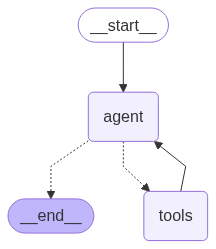

In [ ]:
single_agent

In [ ]:
def call_agent_system(agent, prompt, verbose=False):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 25},
        stream_mode="values"
    )
    for event in events:
        if verbose:
            event["messages"][-1].pretty_print()

    print('\nFinal Response:')
    display(Markdown(event["messages"][-1].content))

## Start Tracing & Monitoring your Agent

Enable LangSmith tracing to capture agent runs, then execute sample utilization review queries to observe how the agent interacts with tools.  

- Run test prompts through the agent (e.g., patient cases) and log traces to LangSmith.  
- Inspect recorded traces in the LangSmith UI to review inputs, tool calls, and final outputs.  
- Use LangSmith’s **monitoring dashboards** to track latency, errors, and token usage across runs.  



### Run your Agent

In [ ]:
%%time
import time

for patient_id in ["P101", "P102", "P103", "P104", "P105"]:
    prompt = f"Review patient {patient_id} for procedure justification."
    call_agent_system(single_agent, prompt, verbose=False)
    time.sleep(3)


Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The patient's symptoms include abdominal pain and nausea, but they do not exhibit the required RLQ tenderness, which is necessary for the procedure to be considered medically necessary according to the guideline.
- Care recommendation or alternative steps: Recommend monitoring the patient and considering alternative imaging or clinical evaluation before proceeding with a CT scan. If symptoms worsen or if RLQ tenderness develops, re-evaluate for possible surgical intervention.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms (chest pain, shortness of breath, tachycardia) match the required symptoms for the CT Chest procedure as per the guideline for suspected pulmonary embolism (PE). The clinical context (high probability Wells score and positive D-dimer) further supports the medical necessity of the procedure.
- Care recommendation or alternative steps: Begin anticoagulation and confirm with CTPA.


Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The patient's symptoms include "recurrent headache," which matches one required symptom, but the absence of "nausea" does not meet the guideline criteria for an MRI. The guideline specifies that an MRI is not warranted without neurological deficits or red flags.
- Care recommendation or alternative steps: Start migraine treatment; imaging not necessary unless red flags appear.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms of back pain for more than 6 weeks and neurological deficit (left leg numbness) meet the guideline criteria for the MRI procedure, and conservative treatment has been ineffective.
- Care recommendation or alternative steps: Proceed with the MRI of the lumbar spine; consider referral to physiotherapy for ongoing management of chronic low back pain.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms of fever and cough match the guideline's required symptoms. The patient is immunocompromised, and the initial chest X-ray was inconclusive, justifying the need for a CT Chest.
- Care recommendation or alternative steps: Start empirical antibiotics for Community-Acquired Pneumonia; reserve CT for poor responders.

CPU times: user 962 ms, sys: 82.6 ms, total: 1.04 s
Wall time: 1min 54s


### Check Traces on LangSmith

View the recorded traces in the LangSmith UI to analyze how the agent processed each query.  

- Inspect **inputs and outputs** for every run.  
- Review **tool calls** in sequence to understand the decision-making path.  
- Check **timings, token usage, and costs** to evaluate efficiency.  
- Use the trace viewer to debug unexpected behaviors or confirm correct reasoning.  


![](https://i.imgur.com/k5XC0pU.png)

### Run Agent on Patients

Execute the agent on sample patient cases


- Each query triggers full tool calls and LLM reasoning.  
- All steps are traced to LangSmith for review.  


In [ ]:
%%time

for patient_id in ["P101", "P102", "P103", "P104", "P105"]:
    prompt = f"Review patient {patient_id} for procedure justification."
    call_agent_system(single_agent, prompt, verbose=False)
    time.sleep(3)


Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The patient's symptoms include abdominal pain and nausea, but they do not exhibit the required RLQ tenderness, which is necessary for the procedure to be considered medically necessary according to the guideline.
- Care recommendation or alternative steps: Recommend monitoring the patient and considering a follow-up evaluation. If symptoms worsen or if there are signs of appendicitis, a CT scan may be warranted later, and surgical referral should be considered if appendicitis is confirmed.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms (chest pain, shortness of breath, tachycardia) match the required symptoms for the CT Chest procedure as per the guideline for suspected pulmonary embolism (PE). The clinical context (high Wells score and positive D-dimer) further supports the medical necessity of the procedure.
- Care recommendation or alternative steps: Begin anticoagulation and confirm with CTPA.


Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: The patient's symptoms include "recurrent headache," which aligns with one of the required symptoms from the guideline. However, the guideline also specifies the need for "nausea" as a required symptom, which the patient does not report. Therefore, the procedure is not medically necessary at this time.
- Care recommendation or alternative steps: Start migraine treatment; imaging not necessary unless red flags appear. Focus on managing symptoms and preventing future episodes.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms of back pain for more than 6 weeks and neurological deficit (left leg numbness) meet the guideline criteria for the MRI procedure, and conservative treatment has been ineffective.
- Care recommendation or alternative steps: Proceed with the MRI of the lumbar spine; continue physiotherapy and monitor neurological symptoms.


Final Response:


- Final Decision: APPROVED
- Decision Reasoning: The patient's symptoms of fever and cough match the guideline's required symptoms. The patient is immunocompromised, and the initial chest X-ray was inconclusive, justifying the need for a CT Chest.
- Care recommendation or alternative steps: Start empirical antibiotics for Community-Acquired Pneumonia; reserve CT for poor responders.

CPU times: user 924 ms, sys: 80.4 ms, total: 1 s
Wall time: 1min 34s


### Check out the traces on LangSmith

You will see a standard processing time of around ~15s per patient review

![](https://i.imgur.com/t1Nzt5D.png)

### Monitoring your Agent

Use LangSmith’s dashboards to track the health and performance of your agent over time.  

- Access **pre-built dashboards** to view key metrics such as latency, error rates, token usage, and costs.  
- Create **custom dashboards** to monitor metrics tailored to your use case.  
- Filter by project, environment, or run tags to analyze performance across different deployments.  
- Use monitoring insights to detect regressions, optimize efficiency, and improve reliability before scaling to production.  


![](https://i.imgur.com/VlGeRMP.png)

## Evaluate your Utilization Review AI Agent

Assess the performance and reliability of the utilization review agent using LangSmith datasets and evaluators.  

- **Create Evaluation Dataset**: Build a dataset of patient queries, expected outputs, and reference trajectories.  
- **Define Reference Trajectories**: Capture the ideal sequence of tool calls for each test case.  
- **Upload Dataset to LangSmith**: Store examples centrally to run evaluations at scale.  
- **Goal Accuracy & Reasoning Evaluation**: Use **OpenEvals** with LLM-as-judge to compare the agent’s final outputs against reference answers.  
- **Trajectory Accuracy Evaluation**: Use **AgentEvals** to check if the sequence of agent steps including llm calls, tool calls, responses matches the reference trajectory.  
- **Run Evaluation in LangSmith**: Execute the evaluators against the dataset, view results in the UI, and compare across agent versions.  


### Create an Evaluation Dataset

Prepare a dataset of test cases to systematically evaluate the agent.  

- Define **patient queries** representing different utilization review scenarios.  
- Specify the **expected outputs** for each query
- Store the dataset in a structured format so it can be uploaded and reused in LangSmith evaluations.  


In [ ]:
EVAL_DATASET = 'Agent Evaluation Dataset - DHS 2025 - Demo'

In [ ]:
from langsmith import Client

# Initialize a client
client = Client(timeout_ms=3600000)

ls_dataset = client.create_dataset(
    dataset_name=EVAL_DATASET,
    description="Dataset of sample queries and responses to evaluate the performance of a healthcare utilization review agent",
)

This create an empty evaluation dataset as shown below and we can start adding test records which can be used for evaluation

![](https://i.imgur.com/D8GEEfh.png)

### Add Test Records to the Evaluation Dataset

Populate the evaluation dataset with structured test records for the agent.  

- **Input prompt**: The query or patient case given to the agent.  
- **Output response**: The human-curated or LLM-generated reference answer showing the expected decision, reasoning, and recommendation.  
- **Output trajectory**: Initially left empty; later populated with the full sequence of tool calls, LLM invocations, and responses observed during agent execution.  


In [ ]:
dataset = [
    {
        "inputs": {
            "prompt": "Review patient P101 for procedure justification.",
        },
        "outputs": {
            "response": "The patient is experiencing abdominal pain and nausea, which aligns with two of the three required symptoms for a CT Abdomen in suspected appendicitis cases. However, the absence of RLQ (right lower quadrant) tenderness means the criteria are not fully met. Based on the guidelines, this case needs further review before proceeding with imaging. It is best to monitor the patient and consider clinical re-evaluation or alternative diagnostic approaches before ordering a CT scan.",
            "trajectory": []
        }
    },
    {
        "inputs": {
            "prompt": "Review patient P102 for procedure justification.",
        },
        "outputs": {
            "response": "This patient's symptoms include chest pain, shortness of breath, and tachycardia, which match the guideline criteria for a CT Chest in suspected pulmonary embolism. In addition, the clinical notes mention a high Wells score and a positive D-dimer, both of which support the need for imaging. This procedure is medically appropriate and should be approved. Treatment with anticoagulants can be started, followed by confirmation through CTPA.",
            "trajectory": []
        }
    },
    {
        "inputs": {
            "prompt": "Review patient P103 for procedure justification.",
        },
        "outputs": {
            "response": "The patient is presenting with recurrent headaches, which partially aligns with the guideline for an MRI Brain in migraine cases. However, the guideline also requires the presence of nausea or red flags, which are not noted in the record. Since the imaging criteria are not fully met, this case needs further review. It is better to begin migraine treatment and only consider imaging if new concerning symptoms appear.",
            "trajectory": []
        }
    },
    {
        "inputs": {
            "prompt": "Review patient P104 for procedure justification.",
        },
        "outputs": {
            "response": "The patient reports back pain lasting more than 6 weeks along with neurological symptoms. Both are required for an MRI Lumbar Spine according to the guideline. The clinical note also states that physiotherapy has not helped, which further supports the imaging request. This procedure meets all the necessary criteria and is appropriate for approval.",
            "trajectory": []
        }
    },
    {
        "inputs": {
            "prompt": "Review patient P105 for procedure justification.",
        },
        "outputs": {
            "response": "The patient has fever and cough, which align with the core symptoms for diagnosing pneumonia. Although a CT Chest is not typically the first imaging choice, in this case the chest X-ray was inconclusive and the patient is immunocompromised. These factors make advanced imaging justified. This procedure meets the guideline exceptions and should be approved to guide treatment effectively.",
            "trajectory": []
        }
    },
]

### Get Agent Execution Trajectory per Test Record

Execute the agent for each test input and capture the full step-by-step trajectory to use as the reference path.  

- Run the agent on the test record to log **tool calls**, **LLM messages**, inputs, and intermediate outputs.  
- Extract the ordered **trajectory** (all steps from start to final answer) and attach it to the test record.  
- **Curate and validate** the trajectory with domain experts; correct any mistakes before finalizing.  
- Save the approved trajectory as the **reference** for trajectory-based evaluations.  
- Keep runs reproducible (fixed model/version and temperature) so trajectories remain comparable.  


In [ ]:
for record in dataset:
    record['outputs']['trajectory'] = single_agent.invoke({"messages": [("user", record['inputs']['prompt'])]},
                                        {"recursion_limit": 25})['messages']

### What does a Sample Agent Trajectory look like?

It is basically all the execution steps in the agent including tool call requests, responses, agent calls, LLM call\responses etc.

In [ ]:
dataset[0]

{'inputs': {'prompt': 'Review patient P101 for procedure justification.'},
 'outputs': {'response': 'The patient is experiencing abdominal pain and nausea, which aligns with two of the three required symptoms for a CT Abdomen in suspected appendicitis cases. However, the absence of RLQ (right lower quadrant) tenderness means the criteria are not fully met. Based on the guidelines, this case needs further review before proceeding with imaging. It is best to monitor the patient and consider clinical re-evaluation or alternative diagnostic approaches before ordering a CT scan.',
  'trajectory': [HumanMessage(content='Review patient P101 for procedure justification.', additional_kwargs={}, response_metadata={}, id='5d055e81-3dd2-4305-9134-a0ea01be8515'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2fIPR8AXz3cx6s4vR9Js96J3', 'function': {'arguments': '{"patient_id":"P101"}', 'name': 'fetch_patient_record'}, 'type': 'function'}], 'refusal': None}, response_metadat

In [ ]:
!gdown 1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB

Downloading...
From (original): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB
From (redirected): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB&confirm=t&uuid=e92c28c1-46db-43dc-b8b6-55346e668c17
To: /content/agent_utils.py
100% 6.38k/6.38k [00:00<00:00, 21.8MB/s]


In [ ]:
from agent_utils import format_message

In [ ]:
for event in dataset[0]['outputs']['trajectory']:
    format_message(event)

╭────────────────────────────────── 🧑 Human ──────────────────────────────────╮
│ Review patient P101 for procedure justification.                             │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────── ⚙️ Tool Request ───────────────────────────────╮
│                                                                              │
│ 🔧 Tool Call: fetch_patient_record                                           │
│    Args: {                                                                   │
│   "patient_id": "P101"                                                       │
│ }                                                                            │
│    ID: call_2fIPR8AXz3cx6s4vR9Js96J3                                         │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────── 🔧 Tool Output ───────────────────────────────╮
│ {"patient_summary": "Patient

### Upload Evaluation Dataset Records to LangSmith

Send the curated evaluation dataset to LangSmith so it can be reused for automated testing and benchmarking.  

- Use the LangSmith **Client API** to create examples from the test records.  
- Each record includes the **input prompt**, **expected output response**, and the **reference trajectory**.  
- Store the dataset under a clear name for easy lookup and reuse across evaluations.  
- Uploaded datasets appear in the LangSmith UI and can be versioned or shared with team members.  


In [ ]:
client = Client(timeout_ms=3600000)

client.create_examples(
        dataset_id=ls_dataset.id,
        examples=dataset
)

You can now go to LangSmith and see inside the empty dataset, you will have 5 new records which can be used to test and evaluate your agent

![](https://i.imgur.com/XzAjhWm.png)

### Create LLM-as-a-Judge Agent Evaluators

Define three rubric-driven evaluators to score the agent’s final answer and its internal trajectory.

- **Goal Accuracy (`goal_accuracy`)**  
  Compares the agent’s **final decision** (APPROVED / NEEDS REVIEW) against the **human reference answer**.  
  Uses `create_llm_as_judge` with a clinical rubric; evaluates agreement on the core decision, ignoring phrasing/formatting.

- **Goal Reasoning Quality (`goal_reasoning_quality`)**  
  Judges the **quality of reasoning** supporting the final decision relative to the reference.  
  Uses `create_llm_as_judge` to assess whether the explanation is sound, clinically grounded, and aligned with the reference rationale.

- **Trajectory Accuracy (`trajectory_accuracy`)**  
  Evaluates the **step-by-step trajectory** (tool calls + intermediate reasoning) against a **reference trajectory**.  
  Uses `create_trajectory_llm_as_judge` with a rubric for logical progression, medical appropriateness, and efficient tool use; allows minor wording/order variations when semantically equivalent.

**Implementation notes**
- All evaluators are initialized with **`model="openai:gpt-4o-mini"`**, `use_reasoning=True`, and distinct `feedback_key`s.  
- `run_agent()` wraps the LangGraph call and returns `{"response": result["messages"]}` for downstream evaluators.  
- Inputs to evaluators:  
  - `inputs['prompt']` → the test query  
  - `outputs['response'][-1].content` → agent’s final answer (for goal-based evaluators)  
  - `reference_outputs['response']` → reference final answer  
  - `reference_outputs['trajectory']` → reference step sequence (for trajectory evaluator)


In [ ]:
from openevals.llm import create_llm_as_judge
from agentevals.trajectory.llm import create_trajectory_llm_as_judge


def run_agent(inputs):
    """Run graph and track the trajectory it takes along with the final response."""
    result = single_agent.invoke({"messages": [{ "role": "user", "content": inputs['prompt']}]},
                                 config={"env": "test001"})
    return {"response": result["messages"]}

def goal_accuracy(inputs: dict, outputs: dict, reference_outputs: dict):

    GOAL_ACCURACY_SYS_PROMPT = """You are a clinical evaluation expert. Your task is to compare the decision made by an AI medical review assistant against a trusted human reference answer.

    You will be given:
    1. **AI Agent's Final Response**
    2. **Human Reference Answer**

    Focus only on whether the **Final Decision** made by the AI (either "APPROVED" or "NEEDS REVIEW") is medically correct based on the explanation provided in the **Human Reference Answer**.

    Do not penalize the AI for minor differences in phrasing. Instead, verify if the AI's final decision **agrees or disagrees** with the core clinical judgment in the reference.

    Ignore formatting differences, and do not rephrase.


    <input>
    {inputs}
    </input>

    <output>
    {outputs}
    </output>

    Use the reference outputs below to help you evaluate the correctness of the response:

    <reference_outputs>
    {reference_outputs}
    </reference_outputs>
    """

    evaluator = create_llm_as_judge(
        prompt=GOAL_ACCURACY_SYS_PROMPT,
        model="openai:gpt-4o-mini",
        feedback_key="Goal-Accuracy",
        continuous=False,
        use_reasoning=True,
    )
    eval_result = evaluator(
        inputs=inputs['prompt'],
        outputs=outputs['response'][-1].content,
        reference_outputs=reference_outputs['response']
    )
    return eval_result


def goal_reasoning_quality(inputs: dict, outputs: dict, reference_outputs: dict):

    GOAL_REASONING_QUALITY_SYS_PROMPT = """You are a clinical evaluation expert. Your task is to compare the decision made by an AI medical review assistant against a trusted human reference answer.

    You will be given:
    1. **AI Agent's Final Response**
    2. **Human Reference Answer**

    Focus only on whether the **Final Decision** made by the AI (either "APPROVED" or "NEEDS REVIEW") is medically correct based on the explanation provided in the **Human Reference Answer**.

    Do not penalize the AI for minor differences in phrasing. Instead, verify if the AI's final decision **agrees or disagrees** with the core clinical judgment in the reference.

    Ignore formatting differences, and do not rephrase.


    <input>
    {inputs}
    </input>

    <output>
    {outputs}
    </output>

    Use the reference outputs below to help you evaluate the correctness of the response:

    <reference_outputs>
    {reference_outputs}
    </reference_outputs>
    """

    evaluator = create_llm_as_judge(
        prompt=GOAL_REASONING_QUALITY_SYS_PROMPT,
        model="openai:gpt-4o-mini",
        feedback_key="Goal-Good-Reasoning-Quality",
        continuous=False,
        use_reasoning=True,

    )
    eval_result = evaluator(
        inputs=inputs['prompt'],
        outputs=outputs['response'][-1].content,
        reference_outputs=reference_outputs['response']
    )
    return eval_result



def trajectory_accuracy(inputs: dict, outputs: dict, reference_outputs: dict):

    TRAJECTORY_ACCURACY_SYS_PROMPT = """You are a clinical reasoning evaluator with expertise in reviewing multi-step medical AI workflows.

    Your task is to assess the accuracy of an AI medical review agent's internal trajectory — the step-by-step reasoning and tool outputs used to arrive at its final decision.

    <Rubric>
    An accurate trajectory:
    - Makes logical and clinical sense between each step
    - Demonstrates clear and medically appropriate progression of thought
    - Uses tools or steps efficiently and avoids redundant or irrelevant actions
    - Is semantically equivalent to the provided reference trajectory, even if phrasing or order slightly differs
    </Rubric>

    Use the rubric to compare the actual trajectory against the trusted reference trajectory below.

    <reference_trajectory>
    {reference_outputs}
    </reference_trajectory>

    Grade this actual trajectory:

    <trajectory>
    {outputs}
    </trajectory>
    """

    evaluator = create_trajectory_llm_as_judge(
        prompt=TRAJECTORY_ACCURACY_SYS_PROMPT,
        model="openai:gpt-4o-mini",
        feedback_key="Trajectory-Accuracy",
        continuous=False,
        use_reasoning=True,

    )
    eval_result = evaluator(
        inputs=inputs['prompt'],
        outputs=outputs['response'], # send full agent step by step execution trajectory
        reference_outputs=reference_outputs['trajectory']
    )
    return eval_result



### Evaluate your Utilization Review Agent on the Test Dataset with your Custom Evaluators

Run batch evaluations in LangSmith using the curated dataset and the three LLM-as-judge evaluators.  

- Initialize the **LangSmith Client** and load the dataset by name.  
- Provide a runner (`run_agent`) that invokes the LangGraph agent for each test case.  
- Attach the custom evaluators: **Goal Accuracy**, **Goal Reasoning Quality**, and **Trajectory Accuracy**.  
- Call `client.evaluate(...)` to execute the suite over all examples and record results.  
- Review pass/fail labels, comments, and scores in the LangSmith UI; compare runs across model/prompt versions.  
- Use results to spot regressions, refine prompts/tools, and rerun until metrics are stable.  


In [ ]:
client = Client(timeout_ms=3600000)

experiment_results = client.evaluate(
    run_agent,
    data=ls_dataset.name,
    evaluators=[goal_accuracy,
                goal_reasoning_quality,
                trajectory_accuracy],
    experiment_prefix="agent-evals-dhs-",
    num_repetitions=1,
)

View the evaluation results for experiment: 'agent-evals-dhs--b8b72118' at:
https://smith.langchain.com/o/a0ce8312-2910-55c9-8948-b4d123aa5d69/datasets/d711b90a-0264-447d-948a-8ba8d1ab0824/compare?selectedSessions=cd3e280a-1eaf-4242-a97d-bbb2d247d486




0it [00:00, ?it/s]

You can then go to LangSmith and check out the evaluation results as depicted below in a default dashboard view.

![](https://i.imgur.com/vVsyVKN.png)

You can also click on any eval experiment run and drill down into detailed output traces for any experiment as depicted below.

![](https://i.imgur.com/yw5bd5T.png)

## Creating Custom Evaluators

This is only if you want to create your own evaluators without using any libraries

In [ ]:
# # Create your own custom Evaluator functions with custom schema if needed
# def goal_accuracy(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
#     """Evaluate if the final response is equivalent to reference response."""

#     GOAL_ACCURACY_SYS_PROMPT = """You are a clinical evaluation expert. Your task is to compare the decision made by an AI medical review assistant against a trusted human reference answer.

#     You will be given:
#     1. **AI Agent's Final Response**
#     2. **Human Reference Answer**

#     Focus only on whether the **Final Decision** made by the AI (either "APPROVED" or "NEEDS REVIEW") is medically correct based on the explanation provided in the **Human Reference Answer**.

#     Do not penalize the AI for minor differences in phrasing. Instead, verify if the AI's final decision **agrees or disagrees** with the core clinical judgment in the reference.

#     Ignore formatting differences, and do not rephrase. Just return the evaluation in the following JSON format (no markdown):


#     {{
#      "correct_decision": true or false,
#      "explanation": "Concise explanation of whether the AI's decision matches or contradicts the human reference, and why"
#     }}
#     """

#     user = f"""INPUT PROMPT: {inputs['prompt']}
#                HUMAN REFERENCE RESPONSE: {reference_outputs['response']}
#                AI AGENT RESPONSE: {outputs['response'][-1].content}"""

#     result = llm.invoke([{"role": "system", "content": GOAL_ACCURACY_SYS_PROMPT},
#                                {"role": "user", "content": user}]).content

#     if result.startswith("```json"):
#         result = result.replace("```json", "").replace("```", "").strip()
#     result = json.loads(result)
#     return {
#         "key": "goal_accuracy",
#         "score": result["correct_decision"],
#         "comment": result["explanation"]
#     }


# def goal_reasoning_quality(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
#     """Evaluate if the final response is equivalent to reference response."""

#     GOAL_REASONING_QUALITY_SYS_PROMPT = """You are a clinical evaluation expert. Your task is to assess the quality of the **Decision Reasoning** provided by an AI medical review assistant by comparing it to a trusted human reference answer.

#     You will be given:
#     1. **AI Agent's Final Response**
#     2. **Human Reference Answer**

#     Focus only on the **"Decision Reasoning"** part of the AI response. Evaluate whether the reasoning:
#     - Is clinically sound
#     - Accurately reflects key symptoms or criteria from the guideline
#     - Aligns with the explanation and logic in the human reference
#     - Is neither vague nor misleading

#     Do not evaluate the Final Decision itself. You are only evaluating how well the AI justified its decision.

#     Do not penalize for minor wording differences. Focus on clinical accuracy and alignment of the reasoning.

#     Return your evaluation in the following strict JSON format (no markdown):

#     {{
#      "good_reasoning": true or false,
#      "explanation": "Concise explanation of whether the AI's reasoning was medically accurate and aligned with the reference, or why it fell short"
#     }}
#     """

#     user = f"""INPUT PROMPT: {inputs['prompt']}
#                HUMAN REFERENCE RESPONSE: {reference_outputs['response']}
#                AI AGENT RESPONSE: {outputs['response'][-1].content}"""

#     result = llm.invoke([{"role": "system", "content": GOAL_REASONING_QUALITY_SYS_PROMPT},
#                                {"role": "user", "content": user}]).content

#     if result.startswith("```json"):
#         result = result.replace("```json", "").replace("```", "").strip()
#     result = json.loads(result)
#     return {
#         "key": "goal_good_reasoning_quality",
#         "score": result["good_reasoning"],
#         "comment": result["explanation"]
#     }

